In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from draft.simulation_data import synthetic_data
import torch.nn.functional as F

Generating linear sequences: 100%|██████████| 5000/5000 [00:20<00:00, 241.38it/s]


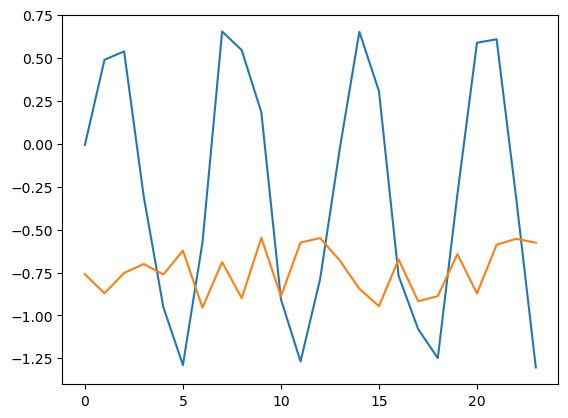

In [2]:
data, label = synthetic_data(10000, 24, 7, 0.5)
y_1_value = data[1,:, 0].tolist()
y_2_value = data[-1,:, 0].tolist()
x_values = torch.arange(24).tolist()
plt.plot(x_values, y_1_value, y_2_value)
dataset = TensorDataset(data, label)
dataloader = DataLoader(dataset, 64, True)

In [3]:
data_val, label_val = synthetic_data(1000, 24, 7, 0.5)
dataset_val = TensorDataset(data_val, label_val)
dataloader_val = DataLoader(dataset_val, 64, True)

Generating linear sequences: 100%|██████████| 500/500 [00:01<00:00, 259.51it/s]


In [4]:
class BiLSTM_softmax(nn.Module):
    def __init__(self):
        super(BiLSTM_softmax, self).__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU()  # ReLU激活函数
        self.bn1 = nn.BatchNorm1d(128)  # 批标准化层
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()  # ReLU激活函数
        self.bn2 = nn.BatchNorm1d(64)  # 批标准化层
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()  # ReLU激活函数
        self.bn3 = nn.BatchNorm1d(32)  # 批标准化层
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 8)
        self.relu4 = nn.ReLU()  # ReLU激活函数
        self.bn4 = nn.BatchNorm1d(8)  # 批标准化层
        self.dropout4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        # print(x.shape)
        h0 = torch.zeros(4, x.size(0), 128).to(x.device)
        c0 = torch.zeros(4, x.size(0), 128).to(x.device)

        output, _ = self.lstm(x, (h0, c0))
        # print(output.shape)
        output = output[:, -1, :]  # 取最后一个时间步的隐藏状态
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.dropout1(output)

        output = self.fc2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.dropout2(output)

        output = self.fc3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.dropout3(output)

        output = self.fc4(output)
        output = self.relu4(output)
        output = self.bn4(output)
        output = self.dropout4(output)

        output = self.fc5(output)
        output = torch.sigmoid(output)

        return output.squeeze(1).to(x.device)

In [7]:
from figure import plot_figure
from train_net import train_val_net
import time
BATCH_SIZE = 128
EPOCH = 1
LR = 0.1
device = "cuda"

def train_BiLSTM_softmax(data_idx=0):
    model_name = f"BiLSTM_softmax_test_{data_idx}"
    my_model = BiLSTM_softmax()
    my_model.to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(my_model.parameters(), lr=LR)

    start_time = time.time()
    info = train_val_net(model_name, EPOCH, my_model, dataloader, dataloader_val, loss_fn, optimizer)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training finished in {elapsed_time:.2f} seconds.")
    plot_figure(info, model_name)

-------第 1 轮训练开始-------
开始时间 2024-05-12 16:53:49
训练次数：100, Loss: 0.14633822441101074, Device:cuda:0
整体测试集上的Loss: 0.005007724524581805
AUC: 1.00
Best threshold: 0.99
Confusion Matrix:
[[500   0]
 [  1 499]]
Specificity: 1.00
Sensitivity: 1.00
Alarm Accuracy: 1.00
Accuracy: 1.00
混淆矩阵，未归一化
模型已保存
Training finished in 1.77 seconds.


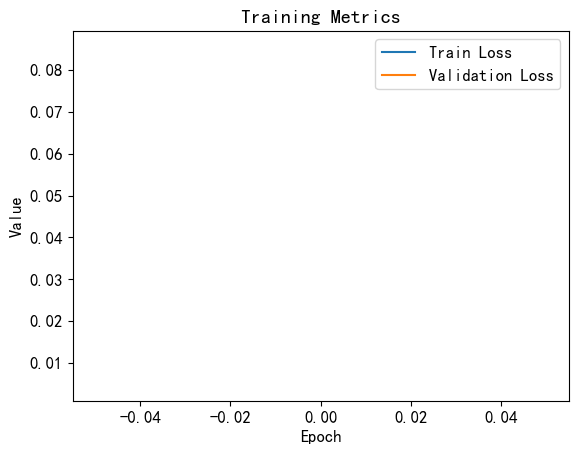

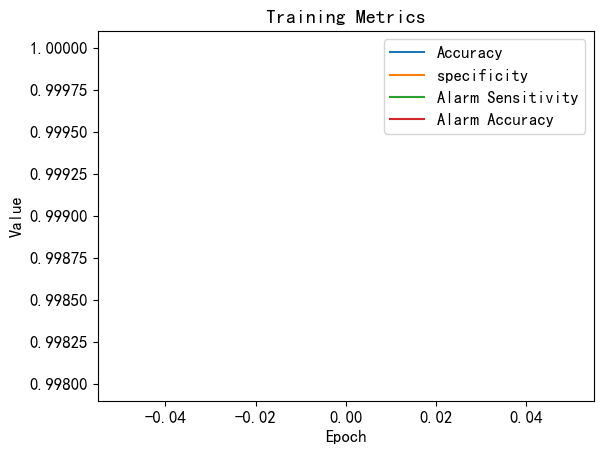

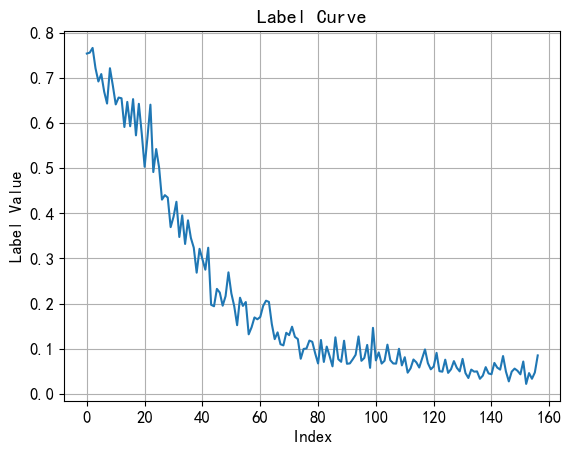

In [8]:
train_BiLSTM_softmax()